In [155]:
# Business Analysis
# Yilong Li

%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
from dateutil import parser
import datetime
import collections

def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + datetime.timedelta(days_ahead)

def diff_weeks(yw1, yw2):
    return (yw2[0] * 52 + yw2[1]) - (yw1[0] * 52 + yw1[1])

def diff_months(yw1, yw2):
    return (yw2[0] * 12 + yw2[1]) - (yw1[0] * 12 + yw1[1])

d = parser.parse('2011-07-02')
next_monday = next_weekday(d, 0) # 0 = Monday, 1=Tuesday, 2=Wednesday...
print(next_monday)
d.isocalendar()[:2]

2011-07-04 00:00:00


(2011, 26)

In [2]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [3]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']


# Temporal Analysis 

In [140]:
top_business = list(db.business.find({'city': 'Las Vegas'}).sort('review_count', -1).limit(1000))
top_business_id = list(map(lambda x: x['business_id'], top_business))

In [119]:
top_business[5000-1]

IndexError: list index out of range

In [141]:
top_review = list(db.review.find({ 'business_id' : { '$in' : top_business_id } }))

In [142]:
review_by_week = {}
stars_by_week = {}
first_year_week = {}
last_year_week = {}

for business_id in top_business_id:
    review_by_week[business_id] = collections.Counter()
    stars_by_week[business_id] = collections.defaultdict(int)

for review in top_review:
    business_id = review['business_id']
    date = parser.parse(review['date'])
    year_week = date.isocalendar()[:2]
    
    if business_id not in first_year_week:
        first_year_week[business_id] = year_week
        last_year_week[business_id] = year_week
    else:
        first_year_week[business_id] = min(first_year_week[business_id], year_week)
        last_year_week[business_id] = max(last_year_week[business_id], year_week)
        
    review_by_week[business_id][year_week] += 1
    stars_by_week[business_id][year_week] += review['stars']

In [40]:
review_by_week

{u'0FUtlsQrJI7LhqDPxLumEw': Counter({(2007, 29): 1,
          (2007, 32): 1,
          (2007, 45): 1,
          (2007, 50): 1,
          (2008, 1): 1,
          (2008, 20): 1,
          (2008, 25): 1,
          (2008, 27): 2,
          (2008, 28): 1,
          (2008, 30): 1,
          (2008, 32): 1,
          (2008, 33): 1,
          (2008, 34): 1,
          (2008, 35): 1,
          (2008, 38): 1,
          (2008, 39): 2,
          (2008, 43): 1,
          (2008, 44): 1,
          (2008, 45): 1,
          (2008, 46): 1,
          (2008, 49): 1,
          (2009, 1): 3,
          (2009, 2): 3,
          (2009, 3): 4,
          (2009, 6): 1,
          (2009, 8): 1,
          (2009, 10): 2,
          (2009, 11): 1,
          (2009, 12): 2,
          (2009, 13): 1,
          (2009, 14): 1,
          (2009, 15): 1,
          (2009, 16): 1,
          (2009, 17): 1,
          (2009, 18): 2,
          (2009, 19): 2,
          (2009, 20): 1,
          (2009, 22): 2,
          (2009, 23): 2,
    

In [122]:
week_to_reach_percentage = collections.defaultdict(list)
percent_week_to_reach_percentage = collections.defaultdict(list)


In [123]:
for review_percentage in[0.1, 0.25, 0.5, 0.75, 0.9]:
    for business in top_business:
        business_id, review_count = business['business_id'], business['review_count']

        list_year_weeks = sorted(review_by_week[business_id].keys())
        running_total = 0

        for year_week in list_year_weeks:
            running_total += review_by_week[business_id][year_week]
            if running_total / float(review_count) >= review_percentage:
                break

        week_to_reach_percentage[review_percentage].append(diff_weeks(first_year_week[business_id], year_week))

    percent_week_to_reach_percentage[review_percentage] = zip(*dict(enumerate(sorted(week_to_reach_percentage[review_percentage]))).items())

<IPython.core.display.Javascript object>


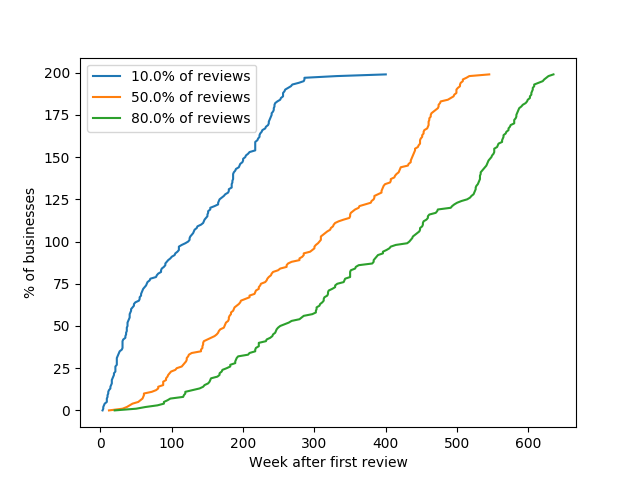

In [88]:
# top 100 
plt.figure()
for review_percentage in[0.1, 0.5, 0.8]:
    pwtrp = percent_week_to_reach_percentage[review_percentage]
    plt.plot(pwtrp[1], pwtrp[0], label='{}% of reviews'.format(review_percentage * 100))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.show()

<IPython.core.display.Javascript object>


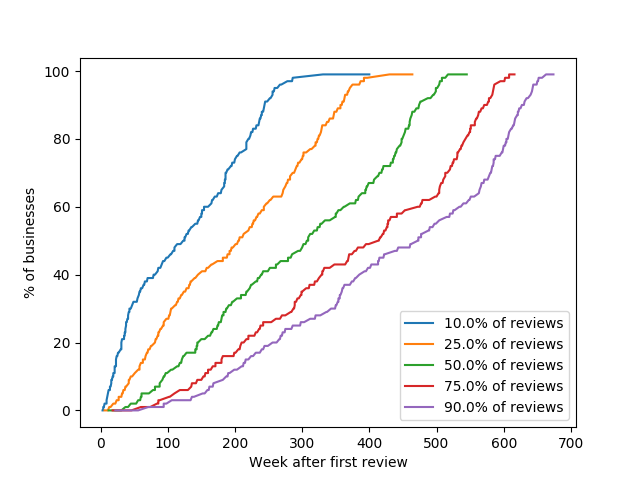

In [95]:
plt.figure()
for review_percentage in[0.1, 0.25, 0.5, 0.75, 0.9]:
    pwtrp = percent_week_to_reach_percentage[review_percentage]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 2, label='{}% of reviews'.format(review_percentage * 100))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/200-restaurants-lasVegas.pdf')
plt.show()

<IPython.core.display.Javascript object>


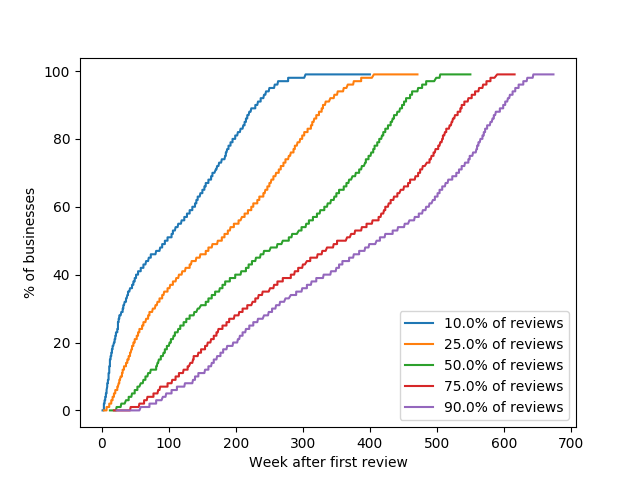

In [102]:
plt.figure()
for review_percentage in[0.1, 0.25, 0.5, 0.75, 0.9]:
    pwtrp = percent_week_to_reach_percentage[review_percentage]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 10, label='{}% of reviews'.format(review_percentage * 100))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/1000-restaurants-lasVegas.pdf')
plt.show()

<IPython.core.display.Javascript object>


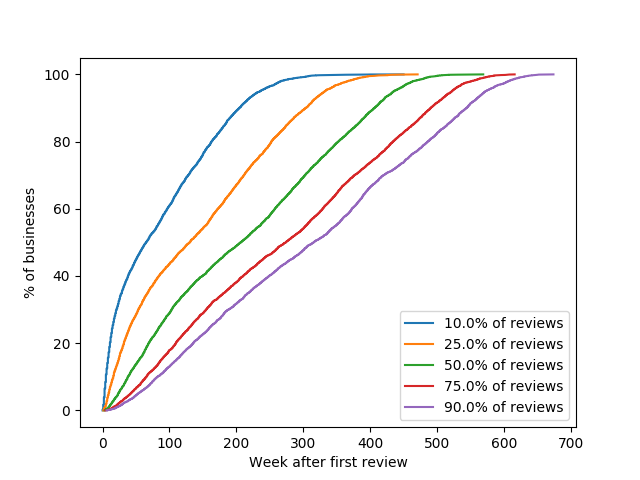

In [112]:
plt.figure()
for review_percentage in[0.1, 0.25, 0.5, 0.75, 0.9]:
    pwtrp = percent_week_to_reach_percentage[review_percentage]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 50.0, label='{}% of reviews'.format(review_percentage * 100))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/5000-restaurants-lasVegas.pdf')
plt.show()

<IPython.core.display.Javascript object>


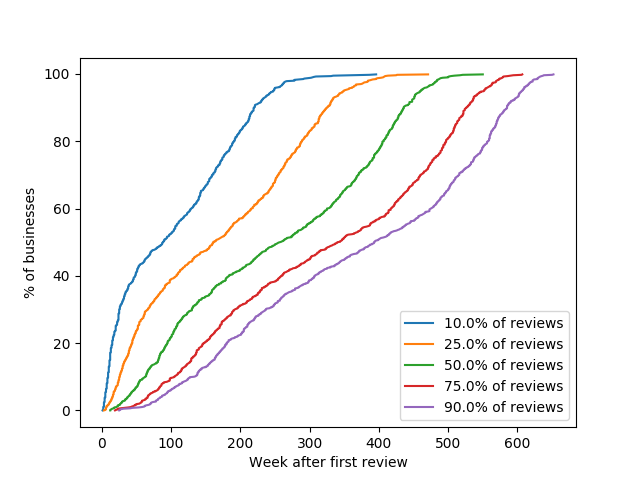

In [124]:
plt.figure()
for review_percentage in[0.1, 0.25, 0.5, 0.75, 0.9]:
    pwtrp = percent_week_to_reach_percentage[review_percentage]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 8.0, label='{}% of reviews'.format(review_percentage * 100))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/200-1000-restaurants-lasVegas.pdf')
plt.show()

In [143]:
week_to_reach_num = collections.defaultdict(list)
percent_week_to_reach_num = collections.defaultdict(list)

In [144]:
for review_number in[100, 200, 500]:
    for business in top_business:
        business_id, review_count = business['business_id'], business['review_count']

        list_year_weeks = sorted(review_by_week[business_id].keys())
        running_total = 0

        for year_week in list_year_weeks:
            running_total += review_by_week[business_id][year_week]
            if running_total >= review_number:
                week_to_reach_num[review_number].append(diff_weeks(first_year_week[business_id], year_week))
                break

    percent_week_to_reach_num[review_number] = zip(*dict(enumerate(sorted(week_to_reach_num[review_number]))).items())

<IPython.core.display.Javascript object>


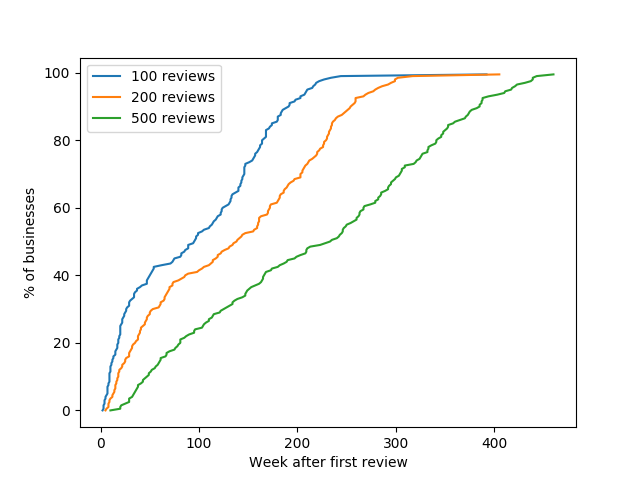

In [138]:
plt.figure()
for review_number in[100, 200, 500]:
    pwtrp = percent_week_to_reach_num[review_number]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 2.0, label='{} reviews'.format(review_number))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/200-restaurants-num-lasVegas.pdf')
plt.show()

<IPython.core.display.Javascript object>


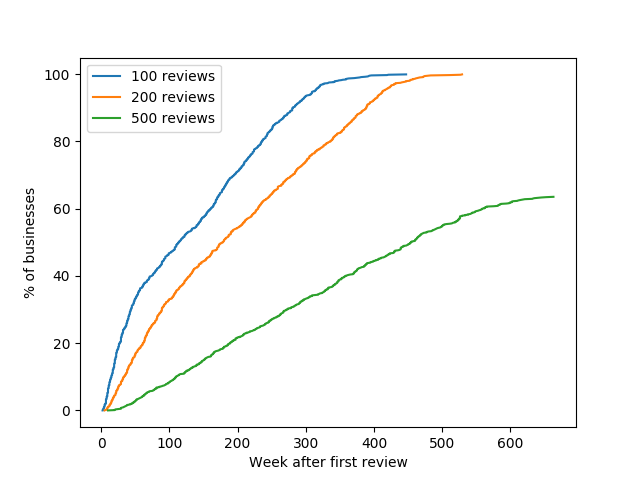

In [145]:
plt.figure()
for review_number in[100, 200, 500]:
    pwtrp = percent_week_to_reach_num[review_number]
    plt.plot(pwtrp[1], np.array(pwtrp[0]) / 10.0, label='{} reviews'.format(review_number))
plt.legend()
plt.xlabel('Week after first review')
plt.ylabel('% of businesses')
plt.savefig('plots/1000-restaurants-num-lasVegas.pdf')
plt.show()

# Popularity burst

In [267]:
top_business = list(db.business.find({'city': 'Las Vegas'}).sort('review_count', -1).limit(500))
top_business_id = list(map(lambda x: x['business_id'], top_business))

In [268]:
top_review = list(db.review.find({ 'business_id' : { '$in' : top_business_id } }))

In [269]:
# All "weeks" are MONTHS here

review_by_week = {}
stars_by_week = {}
first_year_week = {}
last_year_week = {}

for business_id in top_business_id:
    review_by_week[business_id] = collections.Counter()
    stars_by_week[business_id] = collections.defaultdict(int)

for review in top_review:
    business_id = review['business_id']
    date = parser.parse(review['date'])
    year_week = date.isocalendar()[:2]
    year_week = (year_week[0], year_week[1] / 4)
    
    if business_id not in first_year_week:
        first_year_week[business_id] = year_week
        last_year_week[business_id] = year_week
    else:
        first_year_week[business_id] = min(first_year_week[business_id], year_week)
        last_year_week[business_id] = max(last_year_week[business_id], year_week)
        
    review_by_week[business_id][year_week] += 1
    stars_by_week[business_id][year_week] += review['stars']

In [270]:
max_month = collections.defaultdict(int)
max_month_reviews = collections.defaultdict(list)

In [271]:
for business in top_business:
    business_id, review_count = business['business_id'], business['review_count']
    if first_year_week[business_id] < (2011, 12):
        continue

    max_year_week = max(review_by_week[business_id].items(), key=lambda x: x[1])
    
    months_used = min(200, diff_months(first_year_week[business_id], max_year_week[0]))
    max_month[months_used] += 1
    max_month_reviews[months_used].append(max_year_week[1])

In [272]:
max_month_plot = []
max_month_reviews_plot = collections.defaultdict(list)
each_bin = 74/25.0

for x in max_month:
    for i in range(max_month[x]):
        max_month_plot.append(x)
    max_month_reviews_plot[int(x / each_bin)].extend(max_month_reviews[x])
    
avg = [np.average(max_month_reviews_plot[i]) for i in range(25)]
std = [np.std(max_month_reviews_plot[i]) for i in range(25)]

<IPython.core.display.Javascript object>


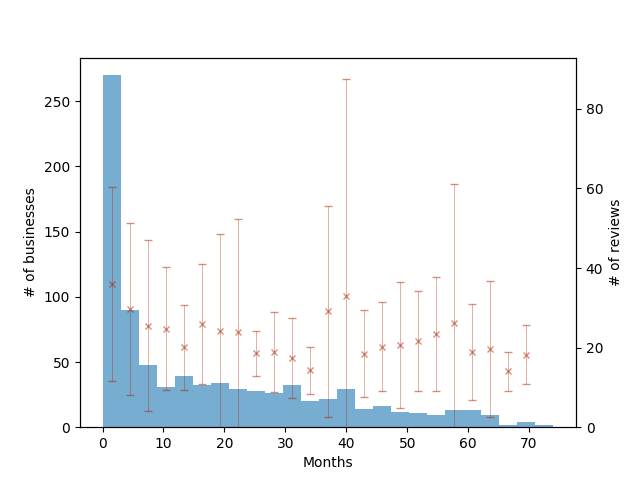

In [259]:
fig, ax1 = plt.subplots()
ax1.hist(max_month_plot, bins=25, alpha=0.6)
ax1.set_xlabel("Months")
ax1.set_ylabel("# of businesses")

ax2 = ax1.twinx()
ax2.errorbar(np.arange(0, 74, each_bin) + each_bin / 2.0, avg, std, linestyle='None', alpha=0.5, capsize=3, linewidth=0.5, markersize=5, color='#aa2200', marker='x')
ax2.set_ylim(0)
ax2.set_ylabel("# of reviews")
plt.savefig("plots/2000-businesses-burst.pdf")
plt.show()

<IPython.core.display.Javascript object>


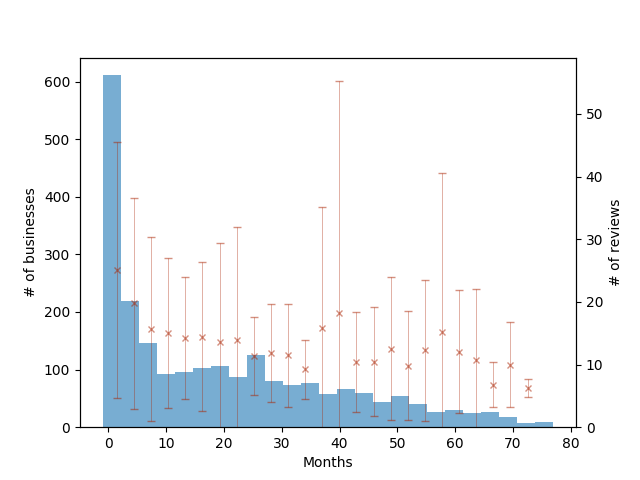

In [266]:
fig, ax1 = plt.subplots()
ax1.hist(max_month_plot, bins=25, alpha=0.6)
ax1.set_xlabel("Months")
ax1.set_ylabel("# of businesses")

ax2 = ax1.twinx()
ax2.errorbar(np.arange(0, 74, each_bin) + each_bin / 2.0, avg, std, linestyle='None', alpha=0.5, capsize=3, linewidth=0.5, markersize=5, color='#aa2200', marker='x')
ax2.set_ylim(0)
ax2.set_ylabel("# of reviews")
plt.savefig("plots/5000-businesses-burst.pdf")
plt.show()

<IPython.core.display.Javascript object>


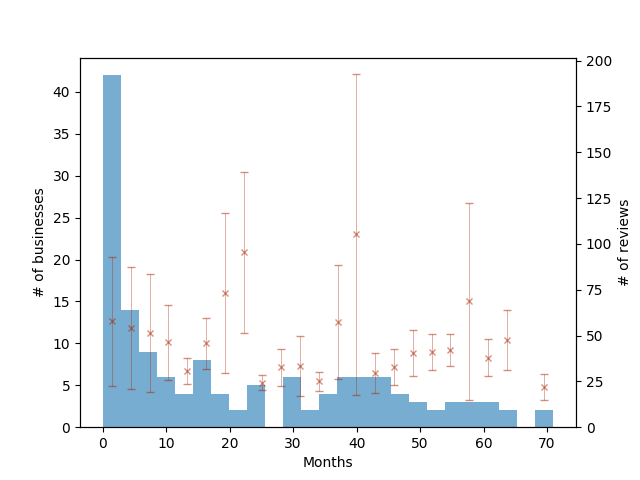

In [276]:
fig, ax1 = plt.subplots()
ax1.hist(max_month_plot, bins=25, alpha=0.6)
ax1.set_xlabel("Months")
ax1.set_ylabel("# of businesses")

ax2 = ax1.twinx()
ax2.errorbar(np.arange(0, 74, each_bin) + each_bin / 2.0, avg, std, linestyle='None', alpha=0.5, capsize=3, linewidth=0.5, markersize=5, color='#aa2200', marker='x')
ax2.set_ylim(0)
ax2.set_ylabel("# of reviews")
plt.savefig("plots/500-businesses-burst.pdf")
plt.show()

In [278]:
db.business.count_documents({})

188593

In [280]:
db.review.count_documents({})

5996996